## Programming Exercise 7: K-means Clustering and Principal Component Analysis
#### Author - Rishabh Jain

In [1]:
import warnings,os
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

from PIL import Image,ImageFilter
from scipy.io import loadmat

### 1&nbsp;&nbsp;&nbsp;&nbsp;K-means Clustering

#### Problem Statement
In this part of the exercise, we will implement the K-means algorithm and use it for image compression by reducing the number of colors that occur in an image to only those that are most common in that image.

#### 1.1&nbsp;&nbsp;&nbsp;&nbsp;Implementing K-means
The K-means algorithm is a method to autmatically cluster similar data together. We have a training set $\{x^{(1)}...x^{(m)}\}$ where $x^{(i)}\epsilon R^{n}$. The intution behind K-means is an iterative procedure that starts by guessing the initial centroids, and then refines the guess by repeatedly assigning examples to their closest centroids and then recomputing the centroids based on assignments.
```
# Initialize Centroids
centroids=kMeansInitCentroids(X,K)
for i in range(iter):
    # Cluster assignment step: Assign each data point to the closest centroid. idx(i) corrsponds to c(i),
    # the index of the centroid assigned to example i
    idx=findClosestCentroids(X,centroids)
    
    # Move centroid step: Compute means based on centroid assignments
    centroids=computeMeans(X,idx,K);
```

The inner loop of the algoritm carries two steps:
1. Assigning each training example $x^{(i)}$ to its closest centroid.
2. Recomputing the mean of each centroid using the points assigned to it.
The K-means algorithm will always converge to some final set of means for the centroids.

##### 1.1.1&nbsp;&nbsp;&nbsp;&nbsp;Find closest centroids
In the "Cluster assignment" phase of the K-means algorithm, **the algorithm assigns every training example $x^{(i)}$ to its closest centroid, given the current position of centroid.**
$$c^{(i)}:=j\text{ that minimizes }||x^{(i)}-\mu||^{2}$$

where $c^{(i)}$ is the index of the centroid that is closes to $x^{(i)}$, $\mu^{(j)}$ is the position of $j^{th}$ centroid.

In [2]:
def findClosestCentroids(X,centroids):
    '''Computes and returns the closest centroid label for the given samples'''
    m,n=X.shape
    # Number of clusters(K)
    K=centroids.shape[0]
    c=np.zeros(m)
    for i in range(m):
        x=X[i,:]
        norm=np.zeros(K)
        for k in range(K):
            norm[k]=np.dot((x-centroids[k,:]),(x-centroids[k,:]).T)
        c[i]=np.argmin(norm)
    return c

##### 1.1.2&nbsp;&nbsp;&nbsp;&nbsp;Computing centroid means
Here, we will calculate the centroid new location based on the examples assigned to that centroid. The cordinates of that centroid is mean of the cordinates of all the samples assigned to it.
$$\mu^{(j)}=\frac{\sum_{i\epsilon c_k}x^{(i)}}{|C_k|}$$

where $C_k$ is the set of examples assigned to that centroid.

In [3]:
def computeCentroids(X,c,K):
    '''Computes and returns the new centroids by computing the means of samples assigned to that centroid'''
    m,n=X.shape
    centroids=np.zeros(shape=(K,n))
    for k in range(K):
        x=X[c==k,:]
        centroids[k,:]=x.mean(axis=0)
    return centroids

#### 1.2&nbsp;&nbsp;&nbsp;&nbsp;K-means on example dataset

#### 1.3&nbsp;&nbsp;&nbsp;&nbsp;Random Initialization
A good strategy for initializing the centroids is to select a random sample from the training set. Example used above first select the random K centroids, finds and compute the closest centroid for each sample in training set.

In [4]:
def runKMeans(X,K,maxIters,plotProgress=False):
    m,n=X.shape
    # Randomly selecting K centroids from X
    indices=np.random.randint(0,m,K)
    centroids=X[indices,:]
    history={}
    for i in range(1,maxIters+1):
        print(f'ITERATION : {i}',end='\r')
        c=findClosestCentroids(X,centroids)
        history[i]=centroids
        centroids=computeCentroids(X,c,K)
    if plotProgress==True and X.shape[1]==2:
        fig,ax=plt.subplots(figsize=(10,8))
        # Plotting points belonging to same cluster
        for k in range(K):
            x=X[c==k,:]
            sns.scatterplot(x[:,0],x[:,1],ax=ax,legend=False)
        # Plotting centroids history
        for i in range(1,maxIters):
            for k in range(K):
                temp=np.array([history[i][k,:],history[i+1][k,:]])
                sns.lineplot(temp[:,0],temp[:,1],color='black')
                sns.scatterplot(temp[:,0],temp[:,1],color='black',marker='x',s=50)
                if i+1==maxIters:
                    sns.scatterplot([temp[1,0]],[temp[1,1]],color='red',marker='x',s=100)
    return c,centroids

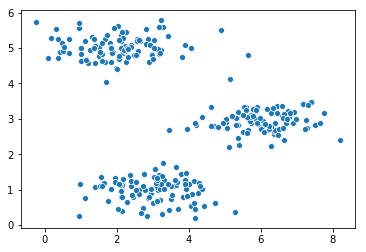

In [5]:
mat=loadmat('ex7data2.mat')
X=mat['X']
sns.scatterplot(X[:,0],X[:,1]);

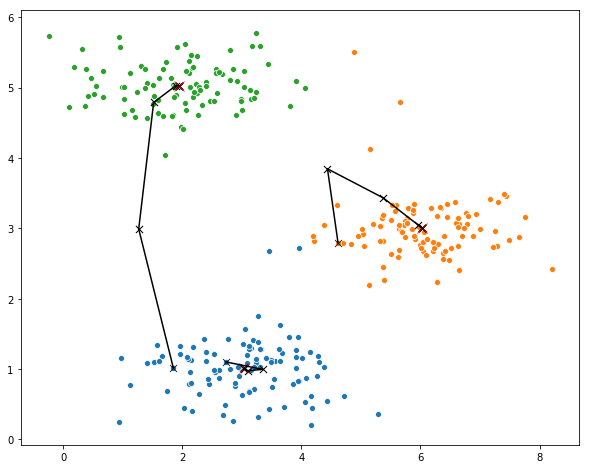

In [6]:
K=3
maxIter=10

labels,centroids=runKMeans(X,K,maxIter,plotProgress=True)

**Note : Red Cross markers are the final centroids of that cluster.**

#### 1.4&nbsp;&nbsp;&nbsp;&nbsp;Image compression with K-means

In this example, we will apply K-means for image compression. In a straightforward 24-bit color representation of an image, each pixel is represented as 8-bit unsigned integers (ranging from 0 to 255) that specify the red, green and blue intensity values. This encoding is often referred to as RGB encoding. **Our image contains thousands of colors, and we will reduce the number of colors to 16 colors.**

Concretely, we will treat every pixel in the original image as a part of our dataset and use the K-means algorithm to find the 16 colors that best group (cluster) the pixels in 3-dimensional space (RGB).

##### 1.4.1&nbsp;&nbsp;&nbsp;&nbsp;K-means on pixels

On loading the image, we get a 3-D matrix whose first two indices identify a pixel position and whose last index represent a red,green and blue value. Here will reshape the 3-D matrix into mX3 matrix of pixel colors and call our K-means function on it.

**EXAMPLE 1:**

In [7]:
K=16
maxIter=5

img=Image.open('images/bird.png')
mat=np.asarray(img)
print(f'IMAGE DIMENSION : {mat.shape}')
X=mat.reshape((-1,3))
print(f'X SHAPE : {X.shape}')

labels,centroids=runKMeans(X,K,maxIter)
print(f'\n\nTOP {K} COLORS :\n\n',centroids)

IMAGE DIMENSION : (128, 128, 3)
X SHAPE : (16384, 3)
ITERATION : 5

TOP 16 COLORS :

 [[135.3538208  117.36236572  91.30651855]
 [         nan          nan          nan]
 [         nan          nan          nan]
 [         nan          nan          nan]
 [         nan          nan          nan]
 [         nan          nan          nan]
 [         nan          nan          nan]
 [         nan          nan          nan]
 [         nan          nan          nan]
 [         nan          nan          nan]
 [         nan          nan          nan]
 [         nan          nan          nan]
 [         nan          nan          nan]
 [         nan          nan          nan]
 [         nan          nan          nan]
 [         nan          nan          nan]]


After finding the top $K=16$ colors to represent the image, we will now assign each pixel position to its closest centroids. This allows us to represent the original image using centroid assignment of each pixel. We have significantly reduced the number of bits that are required to describe the image. The original image required 24 bits for each of 128 x 128 pixels, resulting in total of 128 x 128 x 4 = 363,216 bits. The new representation requires some overhead storage in form of a dictionary of 16 colors, each of which require 24 bits, but the image itself then only requires 4 bits per pixel location. The final number of bits used is therefore 16 x 24 + 128 x 128 X 4 = 65,920 bits, which corresponds to compressing the original image by about a factor of 6.

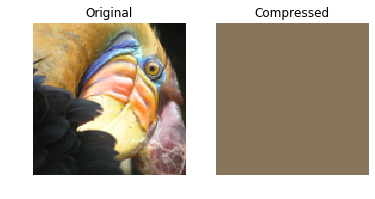

In [8]:
xCompressed=centroids[labels.astype(int),:]
xCompressed=np.uint8(xCompressed.reshape(mat.shape))
fig,ax=plt.subplots(1,2)
ax[0].imshow(img)
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(Image.fromarray(xCompressed))
ax[1].set_title('Compressed')
ax[1].axis('off');

**EXAMPLE 2:**

In [9]:
K=6
maxIter=10

img=Image.open('images/parrot.png')
mat=np.asarray(img)
print(f'IMAGE DIMENSION : {mat.shape}')
X=mat.reshape((-1,3))
print(f'X SHAPE : {X.shape}')

labels,centroids=runKMeans(X,K,maxIter)
print(f'\n\nTOP {K} COLORS :\n\n',centroids)

IMAGE DIMENSION : (200, 200, 3)
X SHAPE : (40000, 3)
ITERATION : 10

TOP 6 COLORS :

 [[209.06126915  52.1804036    5.24094335]
 [238.10874575 208.95500933  28.60430155]
 [ 12.16263586 145.11025164 156.84206404]
 [135.56466389 134.06139203   7.83688281]
 [ 16.79244798  83.90264577  90.7968148 ]
 [ 44.48791931  40.34881539  14.73399015]]


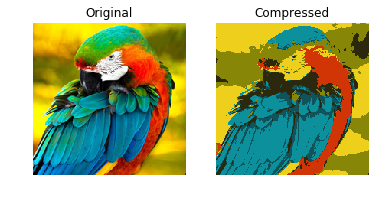

In [10]:
xCompressed=centroids[labels.astype(int),:]
xCompressed=np.uint8(xCompressed.reshape(mat.shape))
fig,ax=plt.subplots(1,2)
ax[0].imshow(img)
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(Image.fromarray(xCompressed))
ax[1].set_title('Compressed')
ax[1].axis('off');

### 2&nbsp;&nbsp;&nbsp;&nbsp;Principal Component Analysis

<img src="images/PCA1.png">

As we can see in figure (A), three axes: L(Length), W(Width) and H(Height) are used to represent the ellipse in 3-D world. So each data point on ellipse can be written as a function of three variables : 
$$Data(i)=f(L(i),W(i),H(i))$$

But, this is not the best way to represent ellipse. We can do the following improvements:  
1. Find the geometric mean of the ellipse, and set it as the coordinate origin.
2. Find the direction along which the ellipse has the longest radius (large variance) and call it as 'Principal Component 1'.
3. Find the another direction perpendicular to the first one and along which the ellipse has the second longest radius and call it 'Principal Component 2'
4. Re-plot the ellipse under the new coordinate system defined by principal component C1 and C2.

In the new coordinate system, data points on ellipse can re-written as a function of two variables:

$$Data(j)=g(C1(j),C2(j))$$

After the coordinate system transformation, we get:
- Fewer variables (lower dimension of variables) in function g as compared to function f.
- No information lost.
>- f$\approx$g
>- The relative geometric positions of all data points remains unchanged.

**That's exactly what PCA do. The term 'Principal Component' denotes new variables we choose to describe our data in lower dimension. All PCA  must satisfy two conditions :**
1. They must be perpendicular (or mathematically orthogonal) to each other.
>- This means that the principal components are NOT linearly correlated with each other.
>- And that's why PCA can reduce the number of veriables without losing much information because the variables in raw data are not independent and correlated variables cause redundancy.
2. These principal components are ordered by the variance in the data points along them. So our data must have the largest variance along the axes of compoenent 1.
>- This means the higher order a component have, the more important it is.
>- Sometimes we sacrifice minor components th further reduce the number of variables. For example: If the first two components contributed 90% of the variance in the data, we might want to focus on them and discard the rest of the components.

**Useful Resources**
- [Linear Transformation](https://www.youtube.com/watch?v=kYB8IZa5AuE&list=PL0-GT3co4r2y2YErbmuJw2L5tW4Ew2O5B&index=4)
- [Eigenvectors and eigenvalues](https://www.youtube.com/watch?v=PFDu9oVAE-g&list=PL0-GT3co4r2y2YErbmuJw2L5tW4Ew2O5B&index=14)

#### 2.1&nbsp;&nbsp;&nbsp;&nbsp;Example Dataset
We will start with a 2D dataset which has one direction of large variation and one of smaller variation.

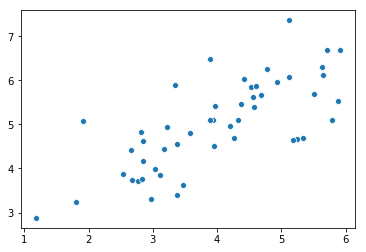

In [11]:
mat=loadmat('./ex7data1.mat')
X=mat['X']
sns.scatterplot(X[:,0],X[:,1]);

#### 2.2&nbsp;&nbsp;&nbsp;&nbsp;Implementing PCA

##### PCA can be implemented in two ways.

1. **EVD (Eigen Value Decomposition)**

>1. First, the values in Data matrix (X of m x n shape) are centered and scaled by subtracting the mean of each features and dividing the resultant by the standard deviation of each feature.
$$X=\frac{X-\bar{X}}{\sigma(X)}$$
>2. Covariance matrix (C of n x n shape) is calculated for the normalized matrix.
```
C=np.cov(X.T)
```
>3. Finally, we calculate the decomposition of the covariance matrix (C). This results in a list of eigenvalues and eigenvectors. The eigenvectors represent the directions or principal components for the reduced subspace of the data matrix whereas the eigenvalues represents the magnitude for the directions.
```
eigenValues,eigenVectors=np.linalg.eig(C)
```
>4. The eigenvectors can be sorted by the eigenvalues in descending order to provide a ranking of the components or axes of the new subspace for data matrix (X).
```
idx=eigenValues.argsort()[::-1]
eigenValues=eigenValues[idx]
eigenVectors=eigenVectors[:idx]
```
>5. A total of m or less components must be selected to comprise the chosen subspace. Ideally, we would select k eigenvectors, called principal components (m X k shape), that have the k largest eigenvalues.
```
principalComponents=eigenVectors[:,:k]
```
>6. Once chosen, data matrix (of shape m X n) can be projected into the subspace (of shape m X k) via matrix multiplication.
```
Z=X.dot(principalComponents)
```

2. **SVD (Singular Value Decomposition)**


In [12]:
def featureNormalize(X):
    '''Returns the normalized matrix'''
    mean=np.mean(X,axis=0)
    std=np.std(X,axis=0)
    xNormalized=(X-mean)/std
    return xNormalized

**PCA using EVD**

EIGENVALUES : 
[1.77094936 0.26986696]

EIGENVECTORS : 
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]


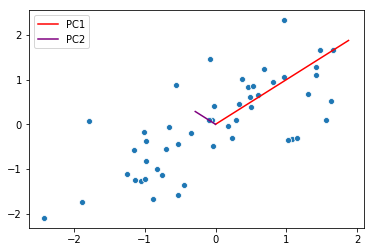

In [13]:
# Normalizing
X=featureNormalize(X)
# Computing covariance
C=np.cov(X.T)
# Computing eigenvectors
eigenValues,eigenVectors=np.linalg.eig(C)
# Sorting eigenvectors based on eigenvalues
idx=eigenValues.argsort()[::-1]
eigenValues=eigenValues[idx]
eigenVectors=eigenVectors[:,idx]

print("EIGENVALUES : ",eigenValues,sep='\n',end='\n\n')
print("EIGENVECTORS : ",eigenVectors,sep='\n')

sns.scatterplot(X[:,0],X[:,1]);
points=list(zip([0,0],1.5*eigenValues[0]*eigenVectors[:,0]))
sns.lineplot(*points,label='PC1',color='red')
points=list(zip([0,0],1.5*eigenValues[1]*eigenVectors[:,1]))
sns.lineplot(*points,label='PC2',color='purple');

#### 2.3&nbsp;&nbsp;&nbsp;&nbsp;Dimensionality Reduction with PCA

After computing the principal components, we can use them to reduce the feature dimension of our dataset by projecting each example onto a lower dimensional space $x^{(i)}\rightarrow z^{(i)}$. In this part of the exercise, **we will use the computed eigenvectors and project the example dataset into a 1-dimensional space.**

##### 2.3.1&nbsp;&nbsp;&nbsp;&nbsp;Projecting the data onto the principal components

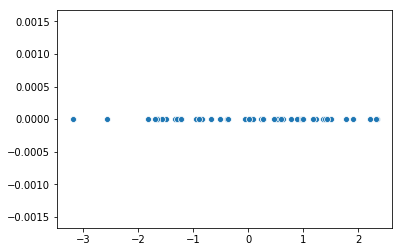

In [14]:
# Selecting top k principal components from eigenvectors matrix
k=1
principalComponents=eigenVectors[:,:k]
# Projecting the centered data matrix using only the top K eigenvectors
Z=X.dot(principalComponents)
sns.scatterplot(Z.reshape(-1),0);

##### 2.3.2&nbsp;&nbsp;&nbsp;&nbsp;Reconstructing an approximation of the data
After projecting the data onto the lower dimensional space, we can approximately recover the data by projecting them back onto the original high dimensional space.

In [15]:
xRec=Z.dot(principalComponents.T)
xRec[:5]

array([[-1.05805279, -1.05805279],
       [ 0.65208021,  0.65208021],
       [-0.86577611, -0.86577611],
       [-1.16238578, -1.16238578],
       [-0.90030292, -0.90030292]])

##### 2.3.3&nbsp;&nbsp;&nbsp;&nbsp;Visualizing the projections
 Here we will plot the projection and the approximate reconstruction to show how the projection affects the data.

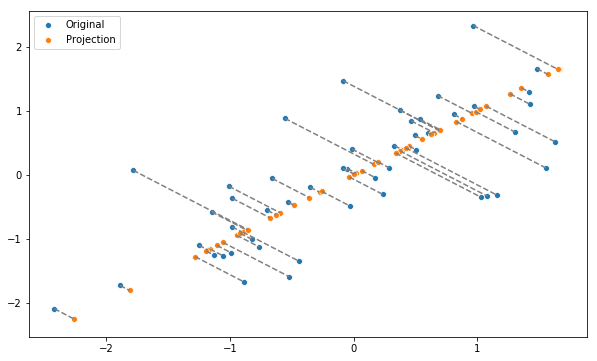

In [16]:
fig,ax=plt.subplots(1,1,figsize=(10,6))
sns.scatterplot(X[:,0],X[:,1],label='Original');
sns.scatterplot(xRec[:,0],xRec[:,1],label='Projection');
for i in range(X.shape[0]):
    points=list(zip(X[i,:],xRec[i,:]))
    sns.lineplot(*points,color='gray')
    ax.lines[i].set_linestyle('--')

**As we can see from the above plot that the projection effectively only retains the information in the direction given by 'PC1'.**

#### 2.4&nbsp;&nbsp;&nbsp;&nbsp;Face Image Dataset

